In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import sys
import os
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from scipy.ndimage import zoom

point_cloud_path = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/training/velodyne/000000.bin'
point_cloud = np.fromfile(point_cloud_path, dtype=np.float32).reshape(-1, 4)

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


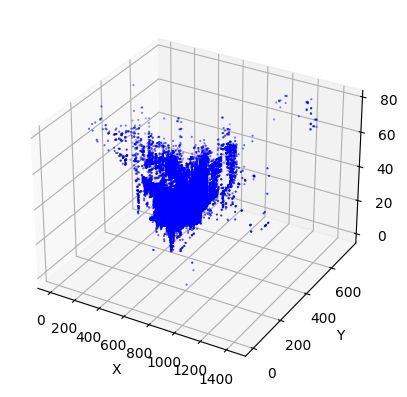

Voxel Grid Shape: (1441, 750, 79)
Number of Occupied Voxels: 48010


In [4]:
def read_kitti_point_cloud(file_path):
    # Read point cloud data from the KITTI dataset .bin file
    return np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)[:, :3]  # Extract x, y, z coordinates

def voxelization(point_cloud, voxel_size):
    # Determine the grid size and resolution
    min_coords = np.min(point_cloud, axis=0)
    max_coords = np.max(point_cloud, axis=0)
    grid_size = np.ceil((max_coords - min_coords) / voxel_size).astype(int)

    # Create an empty voxel grid
    voxel_grid = np.zeros(grid_size, dtype=int)

    # Assign points to voxels
    voxel_indices = ((point_cloud - min_coords) / voxel_size).astype(int)
    for voxel_idx in voxel_indices:
        voxel_grid[tuple(voxel_idx)] += 1  # Increment voxel count

    return voxel_grid

if __name__ == "__main__":
    # Replace 'path_to_kitti_point_cloud.bin' with the actual path to your KITTI dataset .bin file
    point_cloud_data = read_kitti_point_cloud('/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/training/velodyne/000000.bin')

    # Voxelization parameters (you can adjust these as needed)
    voxel_size = 0.1  # Voxel size in meters

    # Perform voxelization
    voxel_grid = voxelization(point_cloud_data, voxel_size)

    # Visualize the voxel grid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get the indices of the occupied voxels
    x, y, z = np.where(voxel_grid > 0)

    # Plot the occupied voxels
    ax.scatter(x, y, z, c='b', marker='.', s=1)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

    # Print the size and shape of the voxel grid
    print("Voxel Grid Shape:", voxel_grid.shape)
    print("Number of Occupied Voxels:", np.sum(voxel_grid > 0))

In [ ]:
def voxelization_with_density(point_cloud, voxel_size):
    # Find the minimum and maximum coordinates of the point cloud
    min_coords = np.min(point_cloud, axis=0)
    max_coords = np.max(point_cloud, axis=0)

    # Calculate the number of voxels in each dimension
    num_voxels_x = int(np.ceil((max_coords[0] - min_coords[0]) / voxel_size))
    num_voxels_y = int(np.ceil((max_coords[1] - min_coords[1]) / voxel_size))
    num_voxels_z = int(np.ceil((max_coords[2] - min_coords[2]) / voxel_size))

    # Initialize the voxel grid and point density grid
    voxel_grid = np.zeros((num_voxels_x, num_voxels_y, num_voxels_z), dtype=np.int32)
    point_density_grid = np.zeros((num_voxels_x, num_voxels_y, num_voxels_z), dtype=np.float32)

    # Loop through each point in the point cloud and populate the voxel grid
    cnt =0
    for point in point_cloud:
        cnt = cnt +1
        # Calculate the voxel index for the current point
        voxel_x = int(np.floor((point[0] - min_coords[0]) / voxel_size))
        voxel_y = int(np.floor((point[1] - min_coords[1]) / voxel_size))
        voxel_z = int(np.floor((point[2] - min_coords[2]) / voxel_size))

        # Check if the voxel indices are within bounds
        if voxel_x >= 0 and voxel_x < num_voxels_x and voxel_y >= 0 and voxel_y < num_voxels_y and voxel_z >= 0 and voxel_z < num_voxels_z:
            voxel_grid[voxel_x, voxel_y, voxel_z] += 1
            point_density_grid[voxel_x, voxel_y, voxel_z] += 1
        else:
            print("Warning: Point outside voxel grid bounds.")

    return voxel_grid, point_density_grid

# Example usage:
# Replace 'path_to_kitti_point_cloud.bin' with the actual path to your KITTI dataset .bin file
point_cloud_data = read_kitti_point_cloud('/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/training/velodyne/000016.bin')

# Voxelization parameters (you can adjust these as needed)
voxel_size = 0.1  # Voxel size in meters

# Perform voxelization with point density
voxel_grid, point_density_grid = voxelization_with_density(point_cloud_data, voxel_size)


In [6]:
# Replace these paths with the actual paths to your dataset folders and label files
training_data_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/training/velodyne/'
training_label_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/training/label_2/'
testing_data_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/testing/velodyne/'

In [7]:
def load_label_file(label_file_path):
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    labels = []
    for line in lines:
        parts = line.split()
        label = parts[0]
        values = [float(part) for part in parts[1:]]
        labels.append((label, values))

    return labels

class_to_index = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person_sitting': 4,
    'Cyclist': 5,
    'Tram': 6,
    'Misc': 7
}

# Define your dataset class and data loaders
class CustomDataset(Dataset):
    def __init__(self, image_folder, voxel_folder, label_folder):
        self.image_paths = sorted(os.listdir(image_folder))
        self.voxel_paths = sorted(os.listdir(voxel_folder))
        self.label_paths = sorted(os.listdir(label_folder))
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to a consistent size
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess image data
        image = Image.open(os.path.join(image_folder, self.image_paths[idx]))  # Load and preprocess image data
        if self.image_transform:
            image = self.image_transform(image)


        # Load and preprocess voxel data
        voxel_data = np.load(os.path.join(voxel_folder, self.voxel_paths[idx]))
        target_shape = (32, 32, 32)
        pad_value = 0
        padded_voxel_data = np.pad(voxel_data, [(0, max(target_shape[0] - voxel_data.shape[0], 0)),
                                                (0, max(target_shape[1] - voxel_data.shape[1], 0)),
                                                (0, max(target_shape[2] - voxel_data.shape[2], 0))], mode='constant', constant_values=pad_value)
        cropped_voxel_data = padded_voxel_data[:target_shape[0], :target_shape[1], :target_shape[2]]
        voxel_data_resized = torch.from_numpy(cropped_voxel_data).float()

        # Load and preprocess label data
        label_lines = open(os.path.join(label_folder, self.label_paths[idx])).readlines()
        target = {}
        #print("hello 1")
        target['boxes'] = []
        target['labels'] = []

        for line in label_lines:
            parts = line.strip().split()
            if parts[0] in ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']:
                target['labels'].append(class_to_index[parts[0]])  # Convert class to index and add to labels
                target['boxes'].append([float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])])

        # Pad the target['boxes'] tensor to the same length
        max_num_boxes = max(len(target['boxes']), 10)#10  # Adjust this based on your maximum expected number of boxes

        target['labels'] = torch.tensor(target['labels'], dtype=torch.int64)  # Convert labels to tensor
        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)

        return image, voxel_data_resized, target

In [12]:
# Define data folders
image_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/Small_training_Kitti/image'
voxel_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/Small_training_Kitti/velodyne'
label_folder = '/content/drive/MyDrive/Occlusion_analysis/YOLO3D-YOLOv4-PyTorch/Voxelnet/dataset/kitti/Small_training_Kitti/label'

In [13]:
def collate_fn_map(batch):
    images, voxel_data, targets = zip(*batch)

    # Determine the maximum voxel size within the batch
    max_voxel_shape = max(data.shape for data in voxel_data)

    # Pad or crop voxel_data tensors to the same size within the batch
    padded_voxel_data = torch.stack(
        [F.pad(data, (0, max_voxel_shape[2] - data.shape[2], 0, max_voxel_shape[1] - data.shape[1], 0, max_voxel_shape[0] - data.shape[0]))
         if data.shape != max_voxel_shape
         else data
         for data in voxel_data]
    )

    return torch.stack(images), padded_voxel_data, targets

In [14]:
# Create data loaders
batch_size = 16
train_dataset = CustomDataset(image_folder, voxel_folder, label_folder)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_map)

In [8]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Modify the first layer to accept custom input channels
        self.resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the last layer to have custom output channels (classes)
        self.resnet.fc = nn.Linear(2048, num_classes)

        # Add a flattening layer
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.resnet(x)
        x = self.flatten(x)
        return x

    def get_output_size(self):
        return 256  # Size of the output features


# Instantiate the custom ResNet-50 model with 10 classes and input_channels=3
custom_resnet = CustomResNet50(num_classes=8, input_channels=3)


# Generate random input tensor with shape (batch_size, 3, 224, 224)
input_tensor = torch.randn(1, 3, 224, 224)

# Pass the input through the backbone
output_features = custom_resnet(input_tensor)
print("Output shape:", output_features.shape)

# Print the architecture of the custom model
#print(custom_resnet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.8MB/s]


Output shape: torch.Size([1, 8])


In [20]:
class VoxNet(nn.Module):
    def __init__(self, n_classes=8, input_shape=(32, 32, 32)):
        super(VoxNet, self).__init__()
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=6,
                                         out_channels=64, kernel_size=3, padding=1)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        x = self.feat(torch.autograd.Variable(torch.rand((1, 6) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, self.n_classes))
        ]))

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        #x = self.mlp(x)
        return x


if __name__ == "__main__":
    voxnet = VoxNet()
    data = torch.rand([1,6, 32, 32, 32])
    voxnet(data)

oup = VoxNet()
data = torch.rand([1, 6, 32, 32, 32])
# Pass the input through the backbone
output_features = oup(data)
print("Output shape:", output_features.shape)

Output shape: torch.Size([1, 216000])


In [31]:
class ConcatenationNetwork(nn.Module):
    def __init__(self, image_backbone, point_cloud_backbone, num_classes=8):#num_anchors
        super(ConcatenationNetwork, self).__init__()
        self.image_backbone = image_backbone
        self.point_cloud_backbone = point_cloud_backbone

        # Update the input size of the fully connected layer
        self.concat_fc = nn.Linear(3383, 8)


    def forward(self, images, voxel_data):
        # Process image input through image backbone
        image_features = self.image_backbone(images)

        # Process point cloud input through point cloud backbone
        voxel_features = self.point_cloud_backbone(voxel_data)

        batch_size = image_features.size(0)
        voxel_features_reshaped = voxel_features[:batch_size, :]

        # Concatenate the image and point cloud features
        concatenated_features = torch.cat((image_features, voxel_features_reshaped), dim=1)

        # Pass through the concatenation layer
        output = self.concat_fc(concatenated_features)
        return output


In [32]:
# Instantiate the image-based backbone (ResNet50) and point cloud backbone (PointCloudBackbone)
image_backbone = CustomResNet50(num_classes=8, input_channels=3)#Simple2DBackbone(in_channels=3, out_channels=256)
point_cloud_backbone = VoxNet() # Adjust input_channels and hidden_size as needed

# Instantiate the concatenation network
concat_model = ConcatenationNetwork(image_backbone, point_cloud_backbone)

# move tensors to GPU if CUDA is available
if use_cuda:
    concat_model.cuda()

In [33]:
optimizer = torch.optim.Adam(concat_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [42]:
# Training loop
num_epochs = 10
log_interval = 10

for epoch in range(num_epochs):
    concat_model.train()
    for batch_idx, (images, voxel_data, labels) in enumerate(train_data_loader):
        print("Images shape:", images.shape)
        print("Voxel data shape:", voxel_data.shape)
        batch_size = images.size(0)
        labels = torch.randint(8, (batch_size,))
        optimizer.zero_grad()
        # Pass images through the image backbone
        image_features = image_backbone(images)
        print("Image features shape:", image_features.shape)

        # Pass voxel data through the voxel backbone
        voxel_features = point_cloud_backbone(voxel_data)

        # Flatten the voxel features
        voxel_features = voxel_features.view(voxel_features.size(0), -1)

        # Print shapes of intermediate features
        print("Voxel features shape:", voxel_features.shape)

        batch_size = image_features.size(0)
        voxel_features_reshaped = voxel_features[:batch_size, :]
        # Concatenate features
        concat_model = ConcatenationNetwork(image_backbone, point_cloud_backbone)
        output = concat_model(images, voxel_data)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_data_loader)}], Loss: {loss.item()}')

print('Training complete')

Images shape: torch.Size([6, 3, 224, 224])
Voxel data shape: torch.Size([6, 32, 32, 32])
Image features shape: torch.Size([6, 8])
Voxel features shape: torch.Size([64, 3375])
Epoch [1/10], Batch [1/1], Loss: 2.0889408588409424
Images shape: torch.Size([6, 3, 224, 224])
Voxel data shape: torch.Size([6, 32, 32, 32])
Image features shape: torch.Size([6, 8])
Voxel features shape: torch.Size([64, 3375])
Epoch [2/10], Batch [1/1], Loss: 2.100167751312256
Images shape: torch.Size([6, 3, 224, 224])
Voxel data shape: torch.Size([6, 32, 32, 32])
Image features shape: torch.Size([6, 8])
Voxel features shape: torch.Size([64, 3375])
Epoch [3/10], Batch [1/1], Loss: 2.0702569484710693
Images shape: torch.Size([6, 3, 224, 224])
Voxel data shape: torch.Size([6, 32, 32, 32])
Image features shape: torch.Size([6, 8])
Voxel features shape: torch.Size([64, 3375])
Epoch [4/10], Batch [1/1], Loss: 2.09112286567688
Images shape: torch.Size([6, 3, 224, 224])
Voxel data shape: torch.Size([6, 32, 32, 32])
Image 

In [ ]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    # Intiatize weights for Linear and Conv2D layers
    if classname.find('Linear') != -1:
        n_inputs =  m.in_features
        y = 1/np.sqrt(n_inputs)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

concat_model.apply(custom_weight_init)